In [ ]:
import os
from pathlib import Path
import json
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import supervision as sv
import pandas as pd
from collections import deque

### Output here your path for the video and the folder 

In [ ]:
import gdown
import cv2
import os

# ID du fichier Google Drive
file_id = "11yuNOoN_FTkQT1yZ8Qc2Un_caPs6Nw3F"
output_path = "video_downloaded.mp4"  # Emplacement local où tu veux enregistrer la vidéo

# Créer l'URL de téléchargement
url = f"https://drive.google.com/uc?export=download&id={file_id}"

# Télécharger la vidéo depuis Google Drive
print("Téléchargement de la vidéo...")
gdown.download(url, output_path, quiet=False)

# Vérifie si la vidéo a bien été téléchargée
if not os.path.exists(output_path):
    print("Erreur lors du téléchargement de la vidéo.")
else:
    print(f"Vidéo téléchargée avec succès à : {output_path}")

# Ouvrir la vidéo avec OpenCV
cap = cv2.VideoCapture(output_path)

# Vérifier si le fichier vidéo s'est bien ouvert
if not cap.isOpened():
    print("Erreur lors de l'ouverture de la vidéo.")
else:
    print("Vidéo ouverte avec succès.")

# Lire et afficher la vidéo frame par frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Afficher la vidéo avec OpenCV
    cv2.imshow('Vidéo Google Drive', frame)

    # Attendre 1 ms pour appuyer sur 'q' pour quitter
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libérer les ressources
cap.release()
cv2.destroyAllWindows()


In [ ]:
video_input_path = "/Users/hugostubler/Documents/Quantum Sport Analytics/Tennis/tennis-ai/data/videos/Alcaraz_Sinner_2025.mp4"
folder_path = "/Users/hugostubler/Documents/Quantum Sport Analytics/Tennis/tennis-analytics/data"
folder_path_back = "Data hit & bounce/per_point_v2"
https://drive.google.com/file/d/11yuNOoN_FTkQT1yZ8Qc2Un_caPs6Nw3F/view?usp=drive_link

## Several functions to overlay the video and to plot the hit & bounce on time series

In [6]:
def get_jsons(i, folder_path_back):

    # Load in another notebook
    with open(f"{folder_path_back}/ball_data_{i}.json", 'r') as f:
        dico_ball = json.load(f)

    return dico_ball



def extract_subvideo_by_frames(mp4_file_string, start_int, end_int, output_path=None):
    # Create output path based on input file name and frame range
    if output_path is None:
        output_path = mp4_file_string.split(".mp4")[0] + f'extract{start_int}_{end_int}.mp4'

    # Open the video file
    cap = cv2.VideoCapture(mp4_file_string)

    # Get the total number of frames and fps in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)  # Read the original fps

    # Ensure start and end are within the frame range
    if start_int < 0 or end_int >= total_frames or start_int > end_int:
        raise ValueError(f"Invalid frame range: start_int={start_int}, end_int={end_int}, total_frames={total_frames}")

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' for .mp4 files
    out = cv2.VideoWriter(output_path, fourcc, fps, (int(cap.get(3)), int(cap.get(4))))
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_int)

    # Loop through and write the selected frames
    for frame_num in range(start_int, end_int + 1):
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)

    # Release resources
    cap.release()
    out.release()

    ### Return the absolute path of the output video
    return os.path.abspath(output_path)


def create_video_full_overlay(
    input_video_path,
    dico_ball,
    output_video_path,
    ball_show=True,
    bounce_show=True,
    hit_show=True,
    tail_duration=1.5,
    global_start_frame=0,

):
    """
    - dico_ball: {global_frame_str or int: {"x": ..., "y": ..., "action": "air"/"bounce"/"hit", "visible": bool}}
    - dico_shots: list[dict] or dict[...] with 'frame', 'player name', 'type', 'speed'
    """
    cap = cv2.VideoCapture(input_video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Changed codec to mp4v for better compatibility
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    # Ball tail: controlled by tail_duration
    ball_tail_length = int(tail_duration * fps)

    # Ball data as DataFrame
    df = pd.DataFrame.from_dict(dico_ball, orient='index')
    df.index = df.index.astype(int)
    df = df.sort_index()
    df[['x', 'y']] = df[['x', 'y']].astype('float')
    df['x_interp'] = df['x'].interpolate(limit_direction='both')
    df['y_interp'] = df['y'].interpolate(limit_direction='both')

    frame_idx_local = 0
    ball_tail_buffer = deque()
    bounce_positions = []
    hit_positions = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        global_frame_idx = global_start_frame + frame_idx_local

        # --- BALL & HITS OVERLAYS ---
        if global_frame_idx in df.index:
            row = df.loc[global_frame_idx]
            x, y = int(row['x_interp']), int(row['y_interp'])
            action = dico_ball.get(str(global_frame_idx), {}).get("action", "air")

            if ball_show:
                ball_tail_buffer.append((x, y, frame_idx_local))
                while ball_tail_buffer and frame_idx_local - ball_tail_buffer[0][2] > ball_tail_length:
                    ball_tail_buffer.popleft()
                for j in range(1, len(ball_tail_buffer)):
                    x1, y1, f1 = ball_tail_buffer[j - 1]
                    x2, y2, f2 = ball_tail_buffer[j]
                    if None in [x1, y1, x2, y2]:
                        continue

                    color = (0, 255, 255)
                    cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 3)

            if bounce_show:
                if action == "bounce":
                    bounce_positions.append((x, y))
                for bx, by in bounce_positions:
                    cv2.ellipse(frame, (bx, by), (12, 6), 0, 0, 360, (0, 255, 255), 2)

            if hit_show:
                if action == "hit":
                    hit_positions.append((x, y))
                # Fixed: was iterating bounce_positions instead of hit_positions
                for hx, hy in hit_positions:
                    cv2.circle(frame, (hx, hy), 20, (255, 0, 0), 2)
                    cv2.line(frame, (hx - 10, hy - 10), (hx + 10, hy + 10), (255, 0, 0), 2)
                    cv2.line(frame, (hx - 10, hy + 10), (hx + 10, hy - 1), (255, 0, 0), 2)

        # CRITICAL FIX: Write the frame to output video!
        out.write(frame)
        frame_idx_local += 1

    cap.release()
    out.release()
    print(f"✅ Full overlay video saved to: {output_video_path}")


import numpy as np
import matplotlib.pyplot as plt

# Example inputs
# dico_ball = { ... }  # your dict
# hits = [frame_ids...]
# bounces = [frame_ids...]

def plot_ball_timeseries(point_ID):
    
    with open(f'{folder_path_back}/ball_data_{point_ID}.json', 'r') as file:
        ball_data = json.load(file)
    ball_data = {int(frame): data for frame, data in ball_data.items()}
    
    bounces_data = {}
    hits_data = {}

    # ---- Iterate through all frames ----
    for frame_str, info in ball_data.items():
        action = info.get("action", None)
        frame = int(frame_str)

        if action == "bounce":
            bounces_data[frame] = info

        elif action == "hit":
            hits_data[frame] = info


    dico_ball = ball_data
    hits = hits_data
    bounces = bounces_data
    # 1) Sort frames and build arrays
    frames = sorted(dico_ball.keys())

    frames_visible = []
    x_vals = []
    y_vals = []

    for f in frames:
        d = dico_ball[f]
        # keep only visible points with valid x,y
        if d.get("visible") and d.get("x") is not None and d.get("y") is not None:
            frames_visible.append(f)
            x_vals.append(d["x"])
            y_vals.append(d["y"])

    frames_visible = np.array(frames_visible)
    x_vals = np.array(x_vals, dtype=float)
    y_vals = np.array(y_vals, dtype=float)

    # 2) Create figure with 2 subplots: x vs frame, y vs frame
    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax_x, ax_y = axes

    # Plot x
    ax_x.plot(frames_visible, x_vals, marker='o', linestyle='-', label='x (pixels)')
    ax_x.set_ylabel("x (pixels)")
    ax_x.legend(loc="upper left")

    # Plot y
    ax_y.plot(frames_visible, y_vals, marker='o', linestyle='-', label='y (pixels)')
    ax_y.set_ylabel("y (pixels)")
    ax_y.set_xlabel("Frame")
    ax_y.legend(loc="upper left")

    # 3) Add vertical lines for hits (green) and bounces (red)
    hits = sorted(hits)
    bounces = sorted(bounces)

    for h in hits:
        ax_x.axvline(h, color='g', linestyle='--', alpha=0.7, label='Hit')
        ax_y.axvline(h, color='g', linestyle='--', alpha=0.7, label='Hit')

    for b in bounces:
        ax_x.axvline(b, color='r', linestyle='--', alpha=0.7,  label='Bounce')
        ax_y.axvline(b, color='r', linestyle='--', alpha=0.7,label='Bounce')

    # Optional: x-limits around data & events
    all_frames_for_limits = frames_visible.tolist() + hits + bounces
    if all_frames_for_limits:
        x_min = min(all_frames_for_limits) - 5
        x_max = max(all_frames_for_limits) + 5
        ax_x.set_xlim(x_min, x_max)

    plt.tight_layout()
    plt.legend()
    plt.show()

# Call it
# plot_ball_timeseries(dico_ball, hits, bounces)



# Plotting the video with Hit & Bounce overlays

In [10]:
# You can create a list of points you want to analyse the int is the point ID 
list_points_1 = [4] #[4, 12, 33, 58, 79, 102, 145, 163, 187, 201]

In [11]:
for point_selected in list_points_1:
    video_output_path = f"front_overlay_{point_selected}.mp4"
    print(f"Processing point {point_selected}...")
    dico_ball = get_jsons(point_selected, folder_path_back)

    first_key = next(iter(dico_ball))
    first_element = {first_key: dico_ball[first_key]}
    last_key = next(reversed(dico_ball))
    last_elem = {last_key: dico_ball[last_key]}

    # FIXED: Use a temporary variable instead of overwriting video_input_path
    extracted_video_path = extract_subvideo_by_frames(video_input_path, int(first_key), int(last_key), output_path=None)
    print(f"Subvideo extracted for point {point_selected}.")
    print(f"Creating overlay video for point {point_selected}...")
    create_video_full_overlay(
    input_video_path=extracted_video_path,
    dico_ball=dico_ball,
    output_video_path=video_output_path,
    ball_show=True,
    bounce_show=True,
    hit_show=True,
    tail_duration=1.5,
    global_start_frame=int(first_key),  # FIXED: Use actual first frame number!

    )
    
    print(f"Overlay video created for point {point_selected} !")

Processing point 4...
Subvideo extracted for point 4.
Creating overlay video for point 4...
✅ Full overlay video saved to: front_overlay_4.mp4
Overlay video created for point 4 !


# Code for plotting the Hit & Bounce on the x,y time series

In [26]:
point_ID = 111

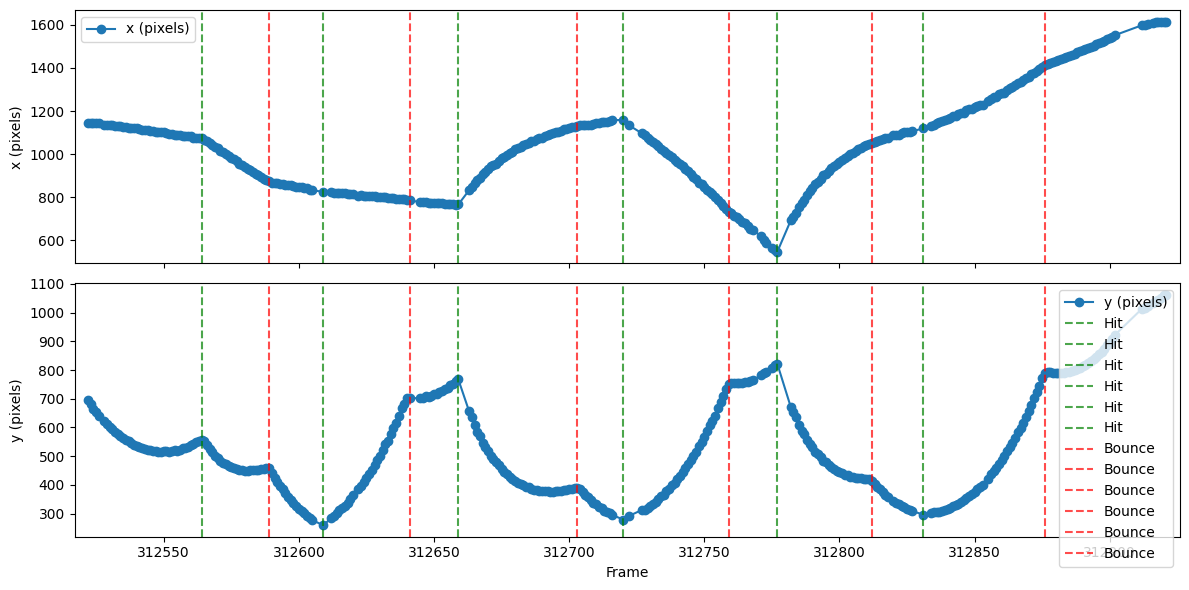

In [27]:
plot_ball_timeseries(point_ID)